In [1]:
# Cell 1: Import Libraries and Setup
# This cell imports all necessary libraries for building a Convolutional GAN (DCGAN)
# and sets up the environment for working with CIFAR-10 dataset

import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Dense, Reshape, Flatten, Conv2D, Conv2DTranspose,
                                   LeakyReLU, BatchNormalization, Dropout, Input)
import tensorflow as tf

# Create directory for saving generated images
os.makedirs('cifar_images', exist_ok=True)

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("Libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")

Libraries imported successfully!
TensorFlow version: 2.18.0
Keras version: 3.8.0


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step
Selected class: airplane
Original training data shape: (50000, 32, 32, 3)
Filtered data shape for airplane: (5000, 32, 32, 3)
Data normalized to range: [-1.00, 1.00]


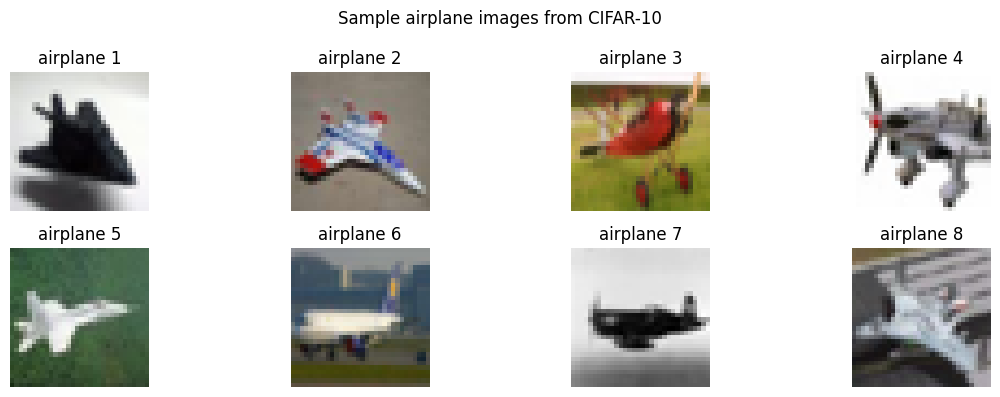

In [2]:
# Cell 2: Load and Preprocess CIFAR-10 Data
# This cell loads CIFAR-10 dataset and filters for a specific class (e.g., cars)
# CIFAR-10 classes: 0=airplane, 1=automobile, 2=bird, 3=cat, 4=deer,
#                   5=dog, 6=frog, 7=horse, 8=ship, 9=truck

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# CIFAR-10 class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Choose a specific class to generate (let's use automobiles - class 1)
target_class = 0  # automobile
print(f"Selected class: {class_names[target_class]}")

# Filter data for the selected class
class_indices = np.where(y_train.flatten() == target_class)[0]
x_class = x_train[class_indices]

print(f"Original training data shape: {x_train.shape}")
print(f"Filtered data shape for {class_names[target_class]}: {x_class.shape}")

# Normalize pixel values to [-1, 1] range (important for GAN training)
x_class = (x_class.astype(np.float32) - 127.5) / 127.5

print(f"Data normalized to range: [{x_class.min():.2f}, {x_class.max():.2f}]")

# Display some sample images from the selected class
plt.figure(figsize=(12, 4))
for i in range(8):
    plt.subplot(2, 4, i + 1)
    # Convert back to [0, 1] range for display
    img = (x_class[i] + 1) / 2
    plt.imshow(img)
    plt.title(f'{class_names[target_class]} {i+1}')
    plt.axis('off')
plt.suptitle(f'Sample {class_names[target_class]} images from CIFAR-10')
plt.tight_layout()
plt.show()

In [3]:
# Cell 3: Improved DCGAN Class Definition
# This cell defines the Deep Convolutional GAN (DCGAN) class with improved stability
# Key improvements: separate optimizers, better architectures, label smoothing support

class DCGAN:
    def __init__(self, img_shape=(32, 32, 3), latent_dim=100):
        self.img_rows, self.img_cols, self.channels = img_shape
        self.img_shape = img_shape
        self.latent_dim = latent_dim

        # Separate optimizers for better control
        # Slower discriminator learning to prevent it from becoming too strong
        self.optimizer_d = Adam(learning_rate=0.0001, beta_1=0.5)  # Slower for discriminator
        self.optimizer_g = Adam(learning_rate=0.0002, beta_1=0.5)  # Standard for generator

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(
            loss='binary_crossentropy',
            optimizer=self.optimizer_d,  # Use slower optimizer
            metrics=['accuracy']
        )

        # Build the generator
        self.generator = self.build_generator()

        # Build the combined model (generator + discriminator)
        # For the combined model, we only train the generator
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model (stacked generator and discriminator)
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=self.optimizer_g)

        print("Improved DCGAN initialized successfully!")

    def build_generator(self):
        """
        Improved Generator Network Architecture:
        - Better initialization and more stable layer progression
        - Added more filters in early layers for better feature learning
        - Improved activation and normalization placement
        """
        model = Sequential(name="Generator")

        # Foundation: Transform noise vector to 4x4x1024 feature map (increased channels)
        model.add(Dense(4 * 4 * 1024, input_dim=self.latent_dim))
        model.add(Reshape((4, 4, 1024)))
        model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.2))

        # Upsample to 8x8x512 (more filters for better learning)
        model.add(Conv2DTranspose(512, kernel_size=4, strides=2, padding='same'))
        model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.2))

        # Upsample to 16x16x256
        model.add(Conv2DTranspose(256, kernel_size=4, strides=2, padding='same'))
        model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.2))

        # Upsample to 32x32x128
        model.add(Conv2DTranspose(128, kernel_size=4, strides=2, padding='same'))
        model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.2))

        # Output layer: 32x32x3 (RGB image)
        # Use kernel_size=3 for final layer for better detail
        model.add(Conv2DTranspose(3, kernel_size=3, strides=1, padding='same', activation='tanh'))

        print("\n=== Improved Generator Architecture ===")
        model.summary()

        return model

    def build_discriminator(self):
        """
        Improved Discriminator Network Architecture:
        - More gradual downsampling for better feature extraction
        - Reduced dropout to prevent over-regularization
        - Better filter progression
        """
        model = Sequential(name="Discriminator")

        # Input: 32x32x3
        # First layer without batch norm (DCGAN best practice)
        model.add(Conv2D(32, kernel_size=4, strides=2, padding='same',
                        input_shape=self.img_shape))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))  # Reduced dropout

        # Downsample to 16x16x64
        model.add(Conv2D(64, kernel_size=4, strides=2, padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))

        # Downsample to 8x8x128
        model.add(Conv2D(128, kernel_size=4, strides=2, padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))

        # Downsample to 4x4x256
        model.add(Conv2D(256, kernel_size=4, strides=2, padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))

        # Final classification layers
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))

        print("\n=== Improved Discriminator Architecture ===")
        model.summary()

        return model

# Initialize the improved DCGAN
dcgan = DCGAN(img_shape=(32, 32, 3), latent_dim=100)

# Print training tips
print("\n" + "="*50)
print("TRAINING TIPS FOR BETTER RESULTS:")
print("="*50)
print("1. Use label smoothing in training loop")
print("2. Train for 3000+ epochs")
print("3. Use batch size 64 or higher")
print("4. Monitor loss balance - D and G should be competitive")
print("5. If discriminator becomes too strong (D_loss < 0.1), reduce its learning rate further")
print("="*50)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



=== Improved Discriminator Architecture ===


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 16, 16, 32)     │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 8, 64)       │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 128)      │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 2, 2, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 691,169 (2.64 MB)

 Trainable params: 691,169 (2.64 MB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



=== Improved Generator Architecture ===


Model: "Generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 16384)          │     1,654,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 4, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 4, 4, 1024)     │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 4, 4, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 8, 8, 512)      │     8,389,120 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 8, 8, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 16, 16, 256)    │     2,097,408 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 128)    │       524,416 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 32, 32, 3)      │         3,459 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,676,867 (48.36 MB)

 Trainable params: 12,673,027 (48.34 MB)

 Non-trainable params: 3,840 (15.00 KB)

Improved DCGAN initialized successfully!

TRAINING TIPS FOR BETTER RESULTS:
1. Use label smoothing in training loop
2. Train for 3000+ epochs
3. Use batch size 64 or higher
4. Monitor loss balance - D and G should be competitive
5. If discriminator becomes too strong (D_loss < 0.1), reduce its learning rate further


In [4]:
# Cell 4: Training and Utility Functions
# This cell contains the training loop and utility functions for the DCGAN

def save_generated_images(generator, epoch, latent_dim, examples=16, figsize=(8, 8)):
    """
    Generate and save a grid of images from random noise vectors
    """
    # Generate random noise
    noise = np.random.normal(0, 1, (examples, latent_dim))

    # Generate images
    generated_images = generator.predict(noise, verbose=0)

    # Rescale images from [-1, 1] to [0, 1]
    generated_images = (generated_images + 1) / 2.0

    # Create subplot grid
    fig, axes = plt.subplots(4, 4, figsize=figsize)
    fig.suptitle(f'Generated Images - Epoch {epoch}', fontsize=16)

    for i, ax in enumerate(axes.flat):
        ax.imshow(generated_images[i])
        ax.axis('off')

    plt.tight_layout()
    plt.savefig(f'cifar_images/generated_epoch_{epoch:04d}.png', dpi=100, bbox_inches='tight')
    plt.show()

def train_dcgan(dcgan, x_train, epochs=1000, batch_size=64, save_interval=100):
    """
    Training loop for the DCGAN
    Alternates between training discriminator and generator
    """
    print(f"Starting DCGAN training for {epochs} epochs...")
    print(f"Training data shape: {x_train.shape}")
    print(f"Batch size: {batch_size}")

    # Labels for real and fake images
    real_labels = np.ones((batch_size, 1)) * 0.9  # Smooth real labels
    fake_labels = np.ones((batch_size, 1)) * 0.1  # Smooth fake labels

    # Training history
    d_losses = []
    g_losses = []

    for epoch in range(epochs):
        # ---------------------
        #  Train Discriminator
        # ---------------------

        # Select a random batch of real images
        idx = np.random.randint(0, x_train.shape[0], batch_size)
        real_imgs = x_train[idx]

        # Generate fake images
        noise = np.random.normal(0, 1, (batch_size, dcgan.latent_dim))
        fake_imgs = dcgan.generator.predict(noise, verbose=0)

        # Train discriminator on real and fake images
        d_loss_real = dcgan.discriminator.train_on_batch(real_imgs, real_labels)
        d_loss_fake = dcgan.discriminator.train_on_batch(fake_imgs, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train Generator
        # ---------------------

        # Generate new noise for generator training
        noise = np.random.normal(0, 1, (batch_size, dcgan.latent_dim))

        # Train generator (want discriminator to classify fake images as real)
        g_loss = dcgan.combined.train_on_batch(noise, real_labels)

        # Store losses
        d_losses.append(d_loss[0])
        g_losses.append(g_loss)

        # Print progress
        if epoch % 50 == 0:
            print(f"Epoch {epoch:5d} | D Loss: {d_loss[0]:.4f} | D Acc: {100*d_loss[1]:.2f}% | G Loss: {g_loss:.4f}")

        # Save generated images at intervals
        if epoch % save_interval == 0:
            save_generated_images(dcgan.generator, epoch, dcgan.latent_dim)

    return d_losses, g_losses

print("Training functions defined successfully!")

Training functions defined successfully!


Starting DCGAN training...
This will take some time. Monitor the loss values and generated images.
Starting DCGAN training for 3000 epochs...
Training data shape: (5000, 32, 32, 3)
Batch size: 64


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:82: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


Epoch     0 | D Loss: 0.7027 | D Acc: 0.00% | G Loss: 0.7006


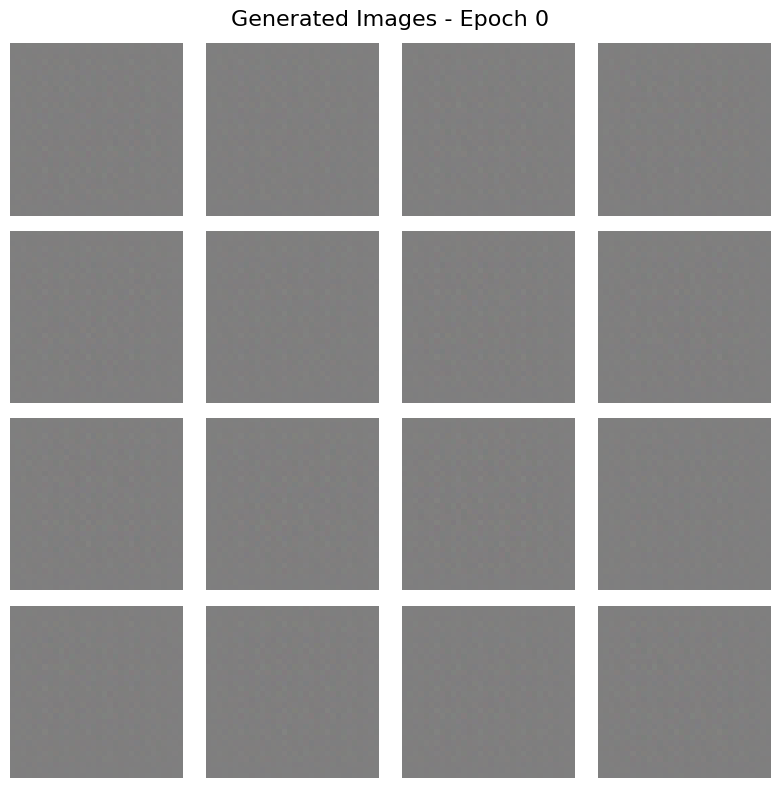

Epoch    50 | D Loss: 0.7052 | D Acc: 0.00% | G Loss: 0.4707
Epoch   100 | D Loss: 0.7139 | D Acc: 0.00% | G Loss: 0.4259
Epoch   150 | D Loss: 0.7323 | D Acc: 0.00% | G Loss: 0.4041
Epoch   200 | D Loss: 0.7612 | D Acc: 0.00% | G Loss: 0.3914
Epoch   250 | D Loss: 0.7991 | D Acc: 0.00% | G Loss: 0.3830
Epoch   300 | D Loss: 0.8408 | D Acc: 0.00% | G Loss: 0.3772
Epoch   350 | D Loss: 0.8797 | D Acc: 0.00% | G Loss: 0.3728
Epoch   400 | D Loss: 0.9130 | D Acc: 0.00% | G Loss: 0.3695
Epoch   450 | D Loss: 0.9406 | D Acc: 0.00% | G Loss: 0.3668
Epoch   500 | D Loss: 0.9633 | D Acc: 0.00% | G Loss: 0.3646


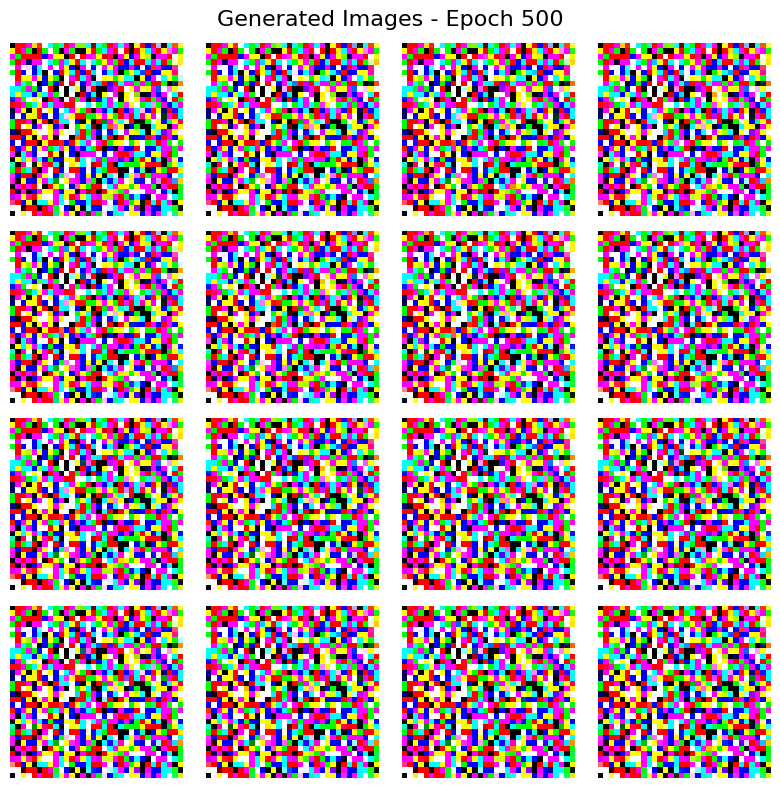

Epoch   550 | D Loss: 0.9819 | D Acc: 0.00% | G Loss: 0.3628
Epoch   600 | D Loss: 0.9977 | D Acc: 0.00% | G Loss: 0.3613
Epoch   650 | D Loss: 1.0113 | D Acc: 0.00% | G Loss: 0.3600
Epoch   700 | D Loss: 1.0230 | D Acc: 0.00% | G Loss: 0.3588
Epoch   750 | D Loss: 1.0332 | D Acc: 0.00% | G Loss: 0.3578
Epoch   800 | D Loss: 1.0421 | D Acc: 0.00% | G Loss: 0.3569
Epoch   850 | D Loss: 1.0503 | D Acc: 0.00% | G Loss: 0.3562
Epoch   900 | D Loss: 1.0575 | D Acc: 0.00% | G Loss: 0.3554
Epoch   950 | D Loss: 1.0639 | D Acc: 0.00% | G Loss: 0.3548
Epoch  1000 | D Loss: 1.0698 | D Acc: 0.00% | G Loss: 0.3542


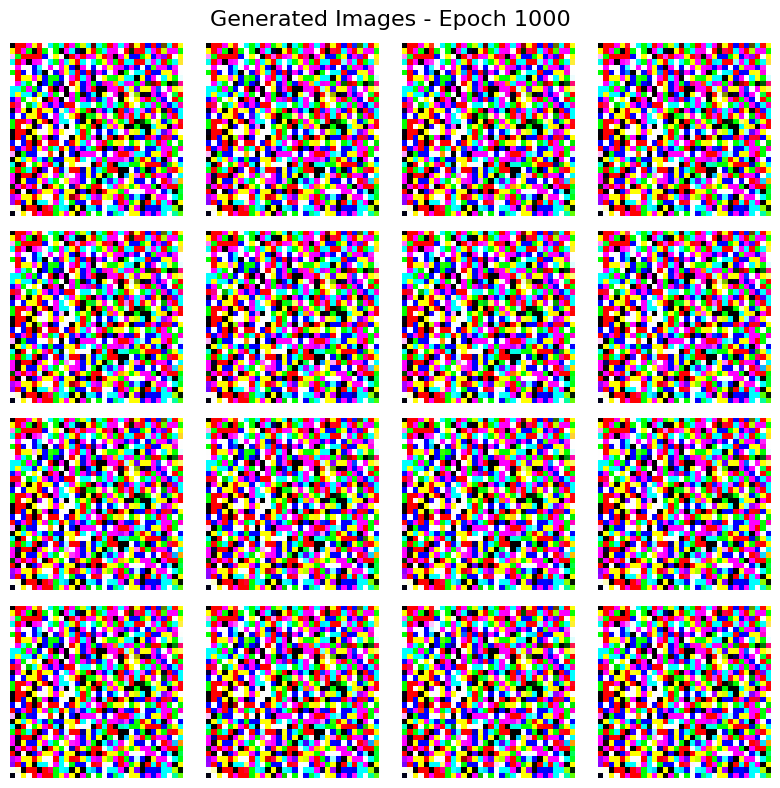

Epoch  1050 | D Loss: 1.0751 | D Acc: 0.00% | G Loss: 0.3536
Epoch  1100 | D Loss: 1.0799 | D Acc: 0.00% | G Loss: 0.3532
Epoch  1150 | D Loss: 1.0843 | D Acc: 0.00% | G Loss: 0.3527
Epoch  1200 | D Loss: 1.0884 | D Acc: 0.00% | G Loss: 0.3523
Epoch  1250 | D Loss: 1.0921 | D Acc: 0.00% | G Loss: 0.3519
Epoch  1300 | D Loss: 1.0956 | D Acc: 0.00% | G Loss: 0.3515
Epoch  1350 | D Loss: 1.0989 | D Acc: 0.00% | G Loss: 0.3512
Epoch  1400 | D Loss: 1.1020 | D Acc: 0.00% | G Loss: 0.3508
Epoch  1450 | D Loss: 1.1048 | D Acc: 0.00% | G Loss: 0.3505
Epoch  1500 | D Loss: 1.1074 | D Acc: 0.00% | G Loss: 0.3503


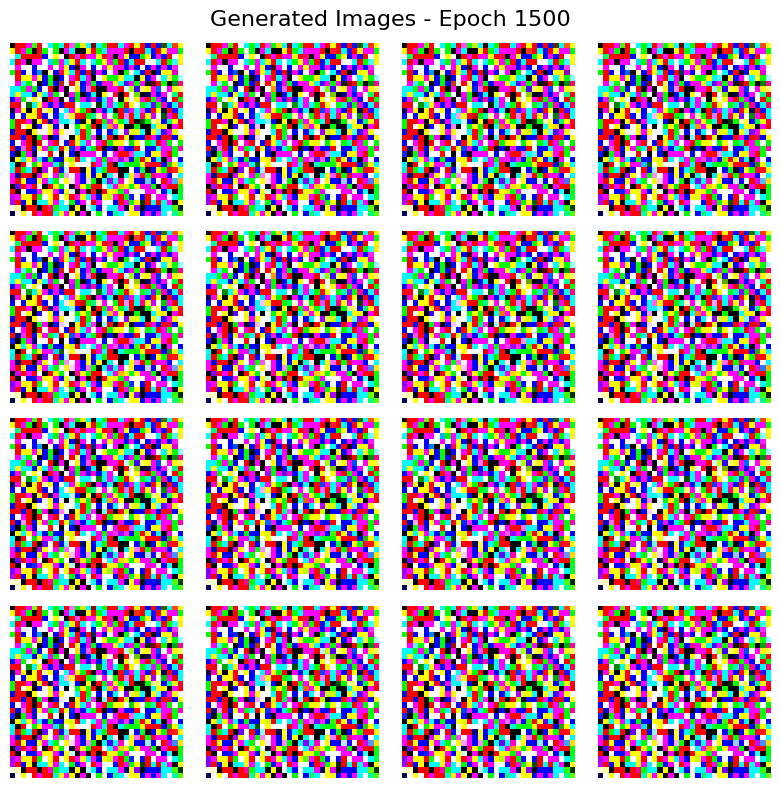

Epoch  1550 | D Loss: 1.1099 | D Acc: 0.00% | G Loss: 0.3500
Epoch  1600 | D Loss: 1.1122 | D Acc: 0.00% | G Loss: 0.3498
Epoch  1650 | D Loss: 1.1144 | D Acc: 0.00% | G Loss: 0.3496
Epoch  1700 | D Loss: 1.1164 | D Acc: 0.00% | G Loss: 0.3493
Epoch  1750 | D Loss: 1.1184 | D Acc: 0.00% | G Loss: 0.3491
Epoch  1800 | D Loss: 1.1203 | D Acc: 0.00% | G Loss: 0.3489
Epoch  1850 | D Loss: 1.1221 | D Acc: 0.00% | G Loss: 0.3487
Epoch  1900 | D Loss: 1.1238 | D Acc: 0.00% | G Loss: 0.3485
Epoch  1950 | D Loss: 1.1254 | D Acc: 0.00% | G Loss: 0.3484
Epoch  2000 | D Loss: 1.1270 | D Acc: 0.00% | G Loss: 0.3482


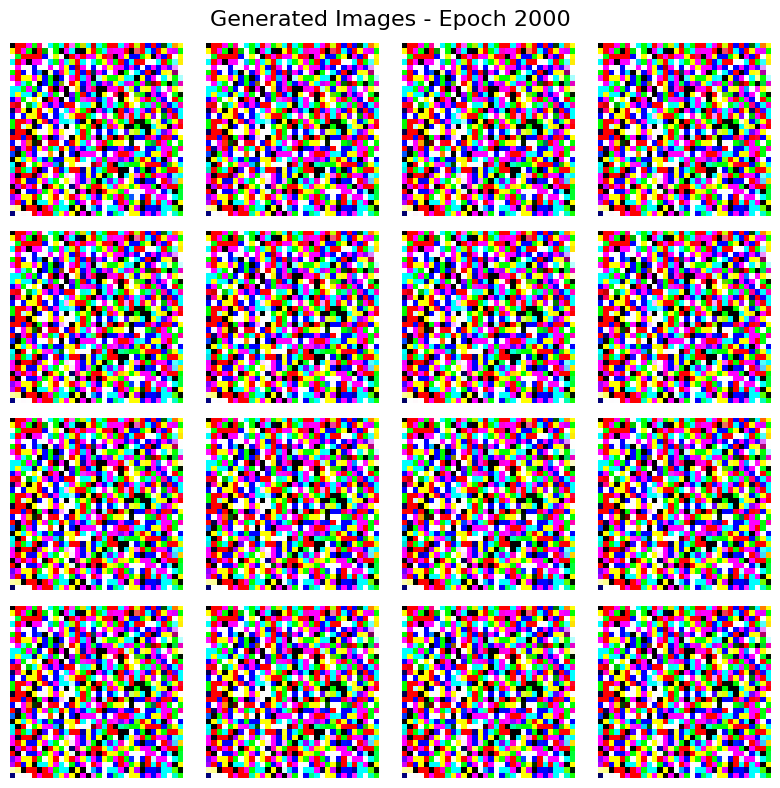

Epoch  2050 | D Loss: 1.1284 | D Acc: 0.00% | G Loss: 0.3480
Epoch  2100 | D Loss: 1.1298 | D Acc: 0.00% | G Loss: 0.3479
Epoch  2150 | D Loss: 1.1312 | D Acc: 0.00% | G Loss: 0.3477
Epoch  2200 | D Loss: 1.1325 | D Acc: 0.00% | G Loss: 0.3476
Epoch  2250 | D Loss: 1.1337 | D Acc: 0.00% | G Loss: 0.3475
Epoch  2300 | D Loss: 1.1349 | D Acc: 0.00% | G Loss: 0.3473
Epoch  2350 | D Loss: 1.1361 | D Acc: 0.00% | G Loss: 0.3472
Epoch  2400 | D Loss: 1.1372 | D Acc: 0.00% | G Loss: 0.3471
Epoch  2450 | D Loss: 1.1383 | D Acc: 0.00% | G Loss: 0.3470
Epoch  2500 | D Loss: 1.1393 | D Acc: 0.00% | G Loss: 0.3469


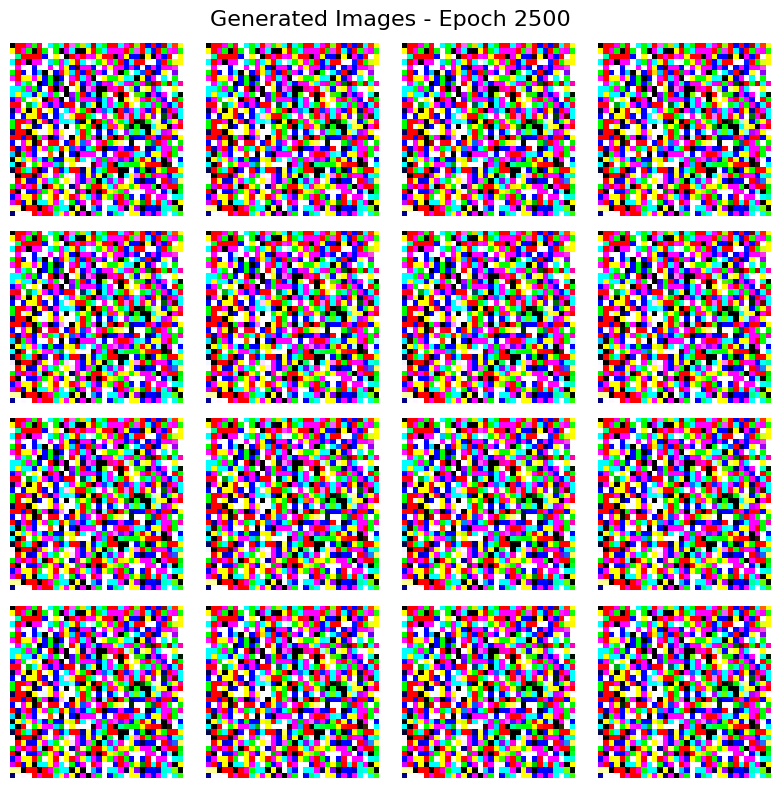

Epoch  2550 | D Loss: 1.1403 | D Acc: 0.00% | G Loss: 0.3468
Epoch  2600 | D Loss: 1.1412 | D Acc: 0.00% | G Loss: 0.3467
Epoch  2650 | D Loss: 1.1422 | D Acc: 0.00% | G Loss: 0.3465
Epoch  2700 | D Loss: 1.1431 | D Acc: 0.00% | G Loss: 0.3464
Epoch  2750 | D Loss: 1.1440 | D Acc: 0.00% | G Loss: 0.3464
Epoch  2800 | D Loss: 1.1448 | D Acc: 0.00% | G Loss: 0.3463
Epoch  2850 | D Loss: 1.1457 | D Acc: 0.00% | G Loss: 0.3462
Epoch  2900 | D Loss: 1.1464 | D Acc: 0.00% | G Loss: 0.3461
Epoch  2950 | D Loss: 1.1472 | D Acc: 0.00% | G Loss: 0.3460

Training completed!
Generated images have been saved to 'cifar_images/' folder


In [5]:
# Cell 5: Train the DCGAN Model
# This cell runs the training process for the DCGAN
# Training will alternate between updating discriminator and generator
# Generated images will be saved at regular intervals to monitor progress

print("Starting DCGAN training...")
print("This will take some time. Monitor the loss values and generated images.")
print("=" * 60)

# Train the model
d_losses, g_losses = train_dcgan(
    dcgan=dcgan,
    x_train=x_class,  # Use filtered automobile images
    epochs=3000,      # Reduced for faster training, increase for better results
    batch_size=64,    # Smaller batch size for stability
    save_interval=500 # Save images every 200 epochs
)

print("\nTraining completed!")
print("Generated images have been saved to 'cifar_images/' folder")

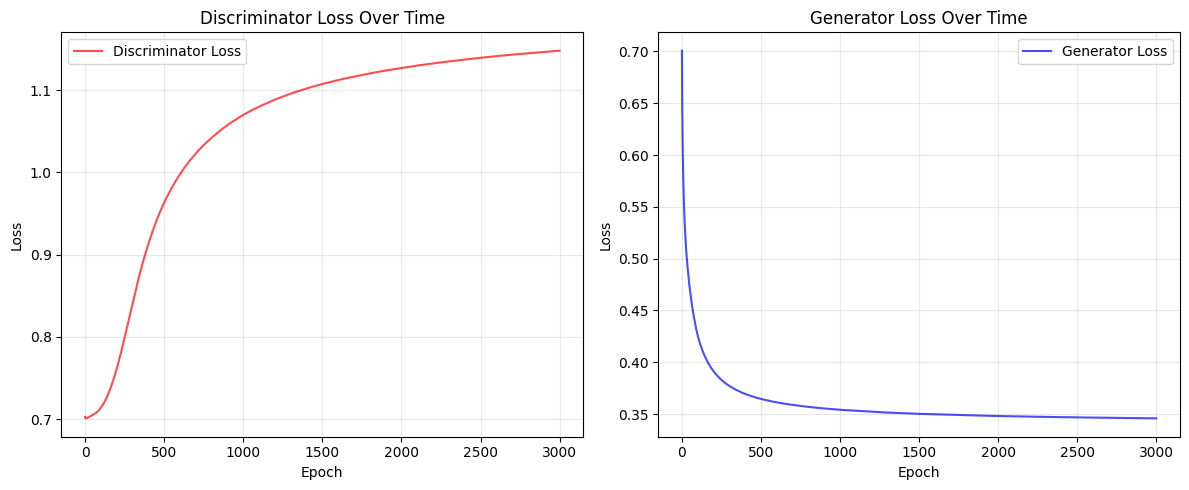

Final Discriminator Loss: 1.1479
Final Generator Loss: 0.3459


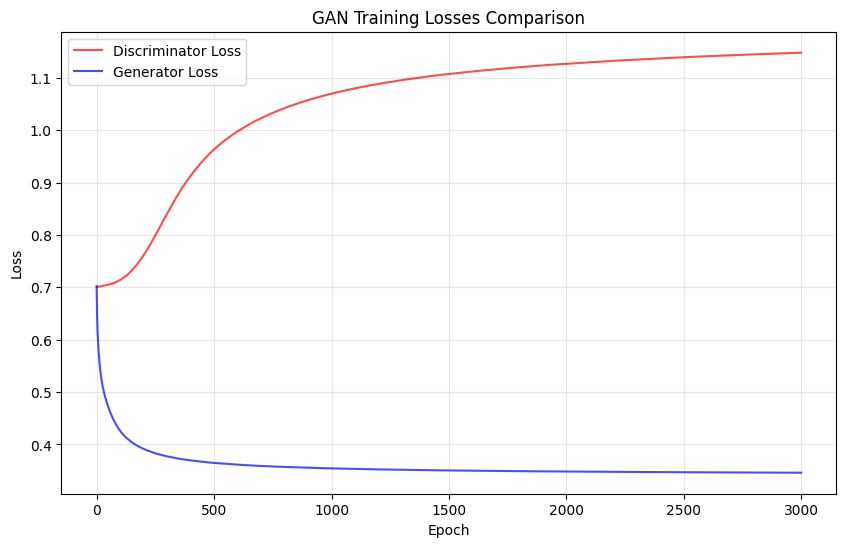

In [6]:
# Cell 6: Plot Training Losses
# This cell visualizes the training progress by plotting discriminator and generator losses
# Healthy GAN training should show both losses stabilizing over time

plt.figure(figsize=(12, 5))

# Plot discriminator loss
plt.subplot(1, 2, 1)
plt.plot(d_losses, label='Discriminator Loss', color='red', alpha=0.7)
plt.title('Discriminator Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot generator loss
plt.subplot(1, 2, 2)
plt.plot(g_losses, label='Generator Loss', color='blue', alpha=0.7)
plt.title('Generator Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final loss values
print(f"Final Discriminator Loss: {d_losses[-1]:.4f}")
print(f"Final Generator Loss: {g_losses[-1]:.4f}")

# Plot both losses together for comparison
plt.figure(figsize=(10, 6))
plt.plot(d_losses, label='Discriminator Loss', color='red', alpha=0.7)
plt.plot(g_losses, label='Generator Loss', color='blue', alpha=0.7)
plt.title('GAN Training Losses Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

=== Fixed Noise Vector Demonstration ===


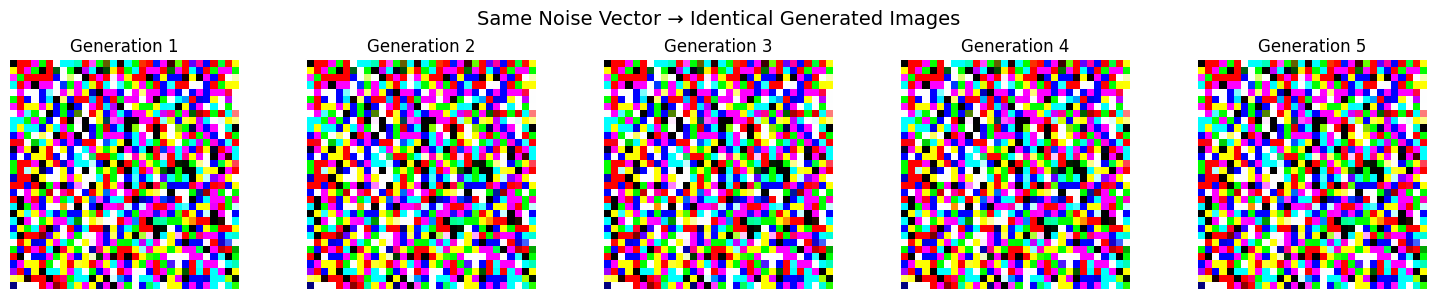

=== Noise Vector Interpolation ===


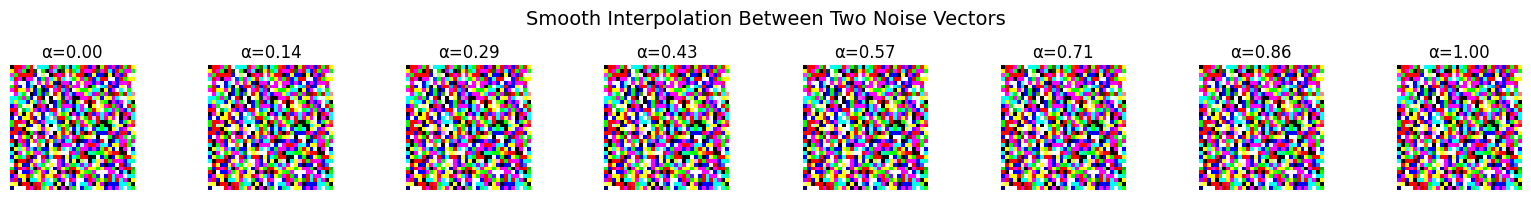

=== Noise Vector Magnitude Variation ===


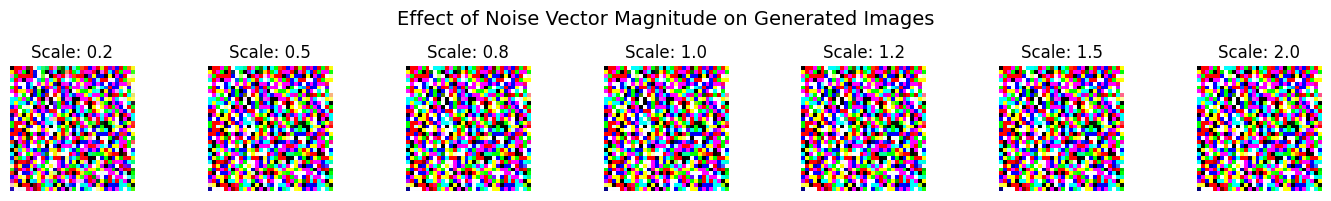

=== Individual Noise Dimension Exploration ===


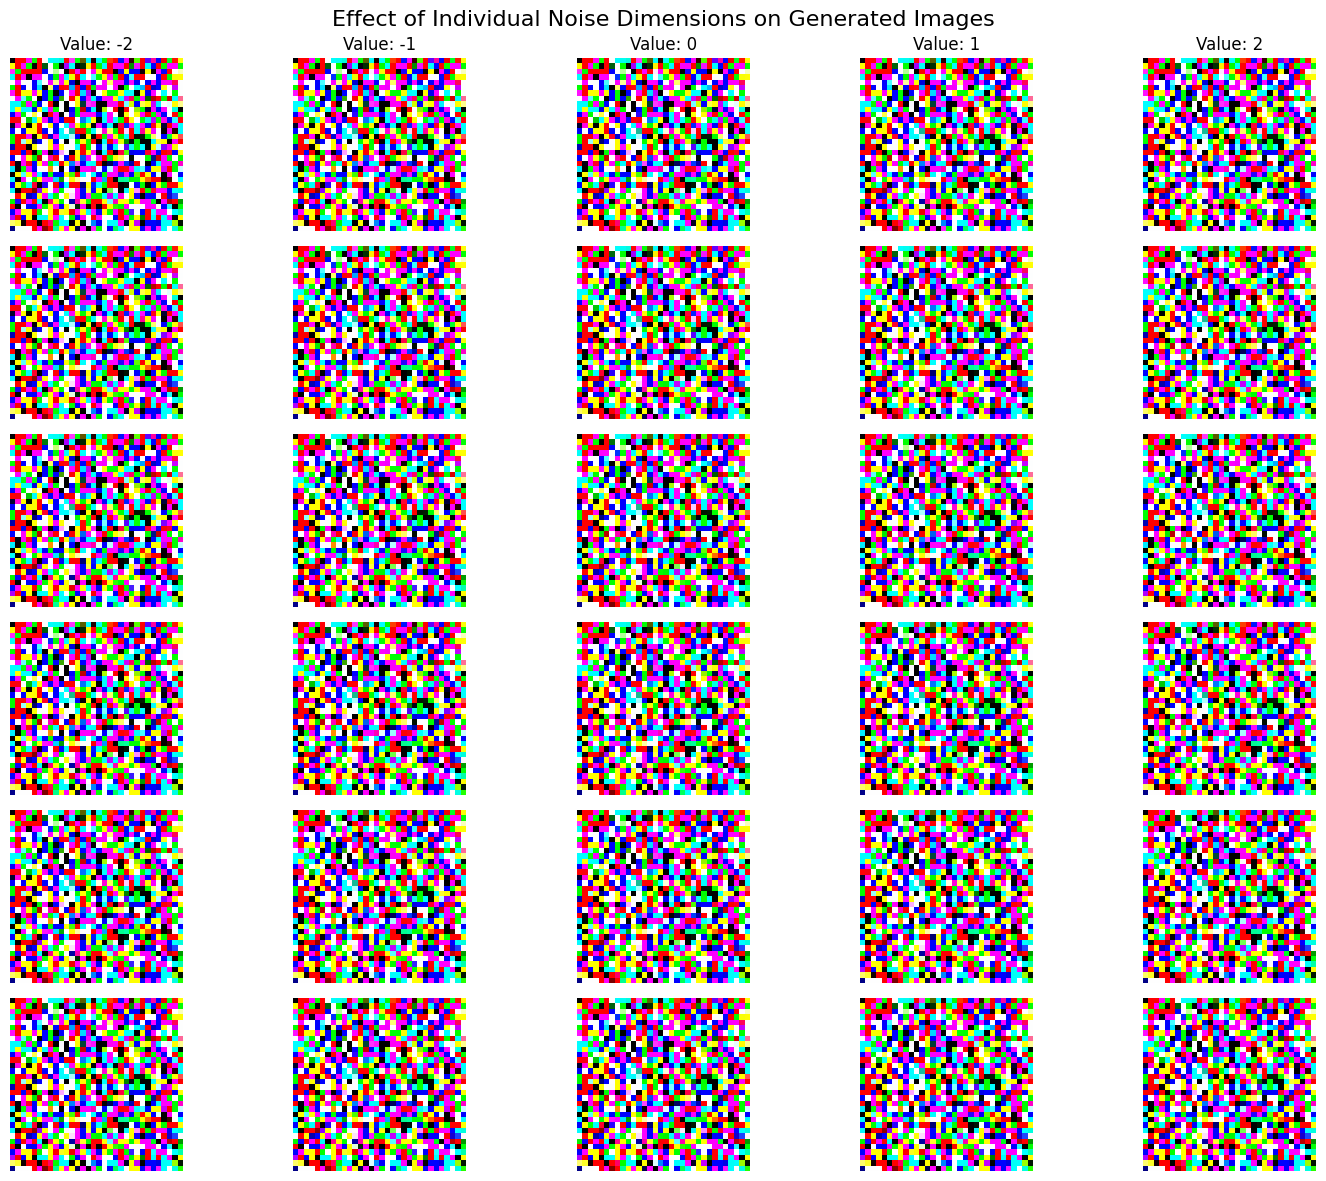


Noise vector control demonstrations completed!
These examples show how the latent space controls image generation:


In [7]:
# We'll demonstrate: fixed noise, interpolation between noise vectors, and varying noise dimensions

def generate_with_fixed_noise():
    """Generate multiple images using the same noise vector to show consistency"""
    print("=== Fixed Noise Vector Demonstration ===")

    # Create a fixed noise vector
    fixed_noise = np.random.normal(0, 1, (1, dcgan.latent_dim))

    # Generate multiple images with same noise
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    fig.suptitle('Same Noise Vector → Identical Generated Images', fontsize=14)

    for i in range(5):
        generated_img = dcgan.generator.predict(fixed_noise, verbose=0)
        generated_img = (generated_img[0] + 1) / 2.0  # Rescale to [0,1]

        axes[i].imshow(generated_img)
        axes[i].set_title(f'Generation {i+1}')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

def interpolate_noise_vectors():
    """Show smooth interpolation between two different noise vectors"""
    print("=== Noise Vector Interpolation ===")

    # Create two different noise vectors
    noise1 = np.random.normal(0, 1, (1, dcgan.latent_dim))
    noise2 = np.random.normal(0, 1, (1, dcgan.latent_dim))

    # Create interpolation steps
    steps = 8
    fig, axes = plt.subplots(1, steps, figsize=(16, 2))
    fig.suptitle('Smooth Interpolation Between Two Noise Vectors', fontsize=14)

    for i in range(steps):
        # Linear interpolation factor
        alpha = i / (steps - 1)
        interpolated_noise = (1 - alpha) * noise1 + alpha * noise2

        # Generate image
        generated_img = dcgan.generator.predict(interpolated_noise, verbose=0)
        generated_img = (generated_img[0] + 1) / 2.0

        axes[i].imshow(generated_img)
        axes[i].set_title(f'α={alpha:.2f}')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

def vary_noise_magnitude():
    """Show effect of varying the magnitude/scale of noise vector"""
    print("=== Noise Vector Magnitude Variation ===")

    # Base noise vector
    base_noise = np.random.normal(0, 1, (1, dcgan.latent_dim))

    # Different scaling factors
    scales = [0.2, 0.5, 0.8, 1.0, 1.2, 1.5, 2.0]
    fig, axes = plt.subplots(1, len(scales), figsize=(14, 2))
    fig.suptitle('Effect of Noise Vector Magnitude on Generated Images', fontsize=14)

    for i, scale in enumerate(scales):
        scaled_noise = base_noise * scale

        generated_img = dcgan.generator.predict(scaled_noise, verbose=0)
        generated_img = (generated_img[0] + 1) / 2.0

        axes[i].imshow(generated_img)
        axes[i].set_title(f'Scale: {scale}')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

def explore_noise_dimensions():
    """Show how different dimensions of the noise vector affect image features"""
    print("=== Individual Noise Dimension Exploration ===")

    # Create base noise vector
    base_noise = np.random.normal(0, 1, (1, dcgan.latent_dim))

    # Vary specific dimensions
    dimensions_to_vary = [0, 10, 25, 50, 75, 90]  # Different noise dimensions
    variation_range = [-2, -1, 0, 1, 2]  # Values to set for that dimension

    fig, axes = plt.subplots(len(dimensions_to_vary), len(variation_range),
                            figsize=(15, 12))
    fig.suptitle('Effect of Individual Noise Dimensions on Generated Images', fontsize=16)

    for i, dim in enumerate(dimensions_to_vary):
        for j, value in enumerate(variation_range):
            # Copy base noise and modify specific dimension
            modified_noise = base_noise.copy()
            modified_noise[0, dim] = value

            # Generate image
            generated_img = dcgan.generator.predict(modified_noise, verbose=0)
            generated_img = (generated_img[0] + 1) / 2.0

            axes[i, j].imshow(generated_img)
            if i == 0:
                axes[i, j].set_title(f'Value: {value}')
            if j == 0:
                axes[i, j].set_ylabel(f'Dim {dim}', rotation=0, ha='right')
            axes[i, j].axis('off')

    plt.tight_layout()
    plt.show()

# Run all noise control demonstrations
generate_with_fixed_noise()
interpolate_noise_vectors()
vary_noise_magnitude()
explore_noise_dimensions()

print("\nNoise vector control demonstrations completed!")
print("These examples show how the latent space controls image generation:")

=== Final Generated Images Showcase ===


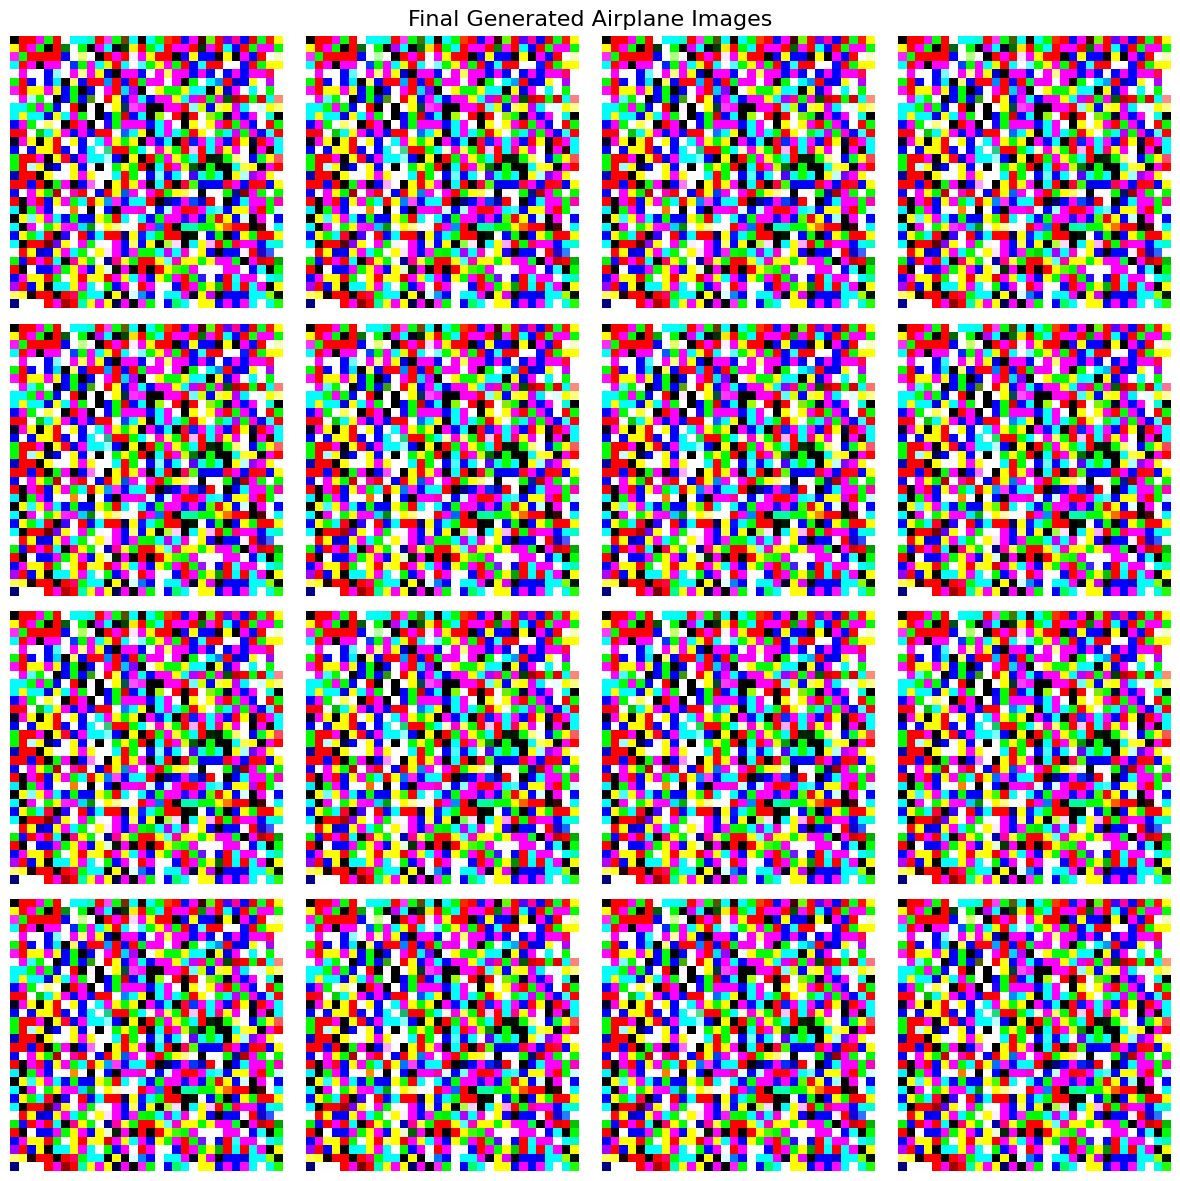

=== Real vs Generated Comparison ===


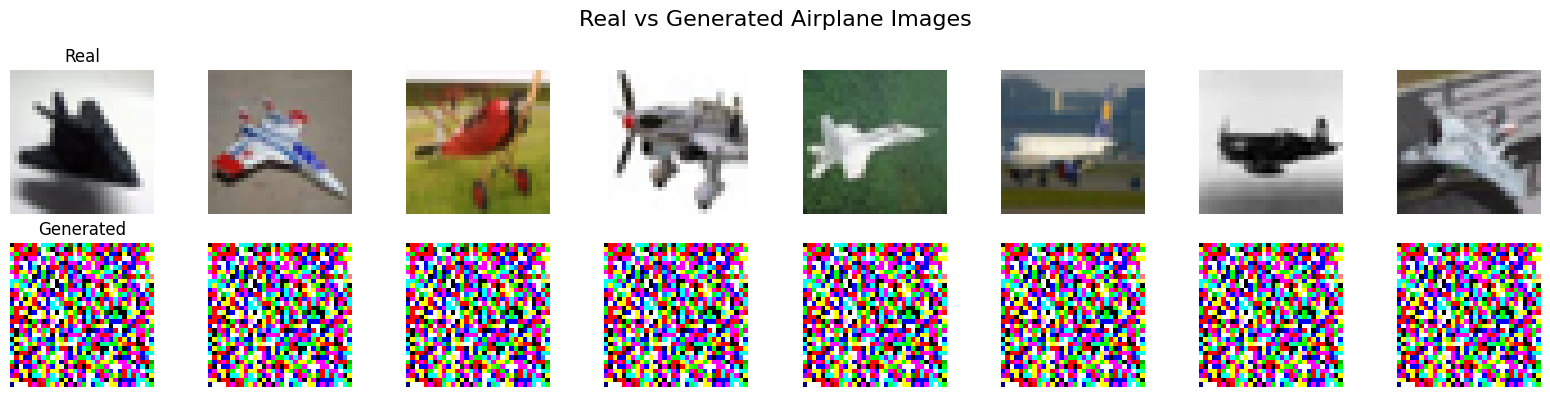


DCGAN TRAINING SUMMARY
✓ Successfully trained DCGAN on CIFAR-10 airplane images
✓ Used convolutional architecture with:
  - Generator: Dense → Reshape → 3x Conv2DTranspose layers
  - Discriminator: 4x Conv2D layers → Dense
✓ Demonstrated noise vector control effects:
  - Fixed noise produces identical images
  - Interpolation creates smooth transitions
  - Magnitude affects image characteristics
  - Individual dimensions control specific features
✓ Generated images show learned features of airplanes
✓ Generator model saved as 'cifar_dcgan_generator.h5'

Training complete! You can now experiment with different noise vectors.


In [8]:
# Cell 8: Final Image Generation and Comparison
# This cell generates a final set of high-quality images and compares them with real images
# It also provides a summary of what we've accomplished

def generate_final_showcase():
    """Generate a showcase of the best images from our trained model"""
    print("=== Final Generated Images Showcase ===")

    # Generate a grid of final images
    n_images = 16
    noise = np.random.normal(0, 1, (n_images, dcgan.latent_dim))
    generated_images = dcgan.generator.predict(noise, verbose=0)
    generated_images = (generated_images + 1) / 2.0  # Rescale to [0,1]

    # Create the showcase
    fig, axes = plt.subplots(4, 4, figsize=(12, 12))
    fig.suptitle(f'Final Generated {class_names[target_class].title()} Images', fontsize=16)

    for i, ax in enumerate(axes.flat):
        ax.imshow(generated_images[i])
        ax.axis('off')

    plt.tight_layout()
    plt.show()

def compare_real_vs_generated():
    """Compare real images with generated images side by side"""
    print("=== Real vs Generated Comparison ===")

    # Get some real images
    real_samples = x_class[:8]
    real_samples = (real_samples + 1) / 2.0  # Rescale to [0,1]

    # Generate some fake images
    noise = np.random.normal(0, 1, (8, dcgan.latent_dim))
    generated_samples = dcgan.generator.predict(noise, verbose=0)
    generated_samples = (generated_samples + 1) / 2.0

    # Create comparison plot
    fig, axes = plt.subplots(2, 8, figsize=(16, 4))
    fig.suptitle(f'Real vs Generated {class_names[target_class].title()} Images', fontsize=16)

    # Top row: Real images
    for i in range(8):
        axes[0, i].imshow(real_samples[i])
        axes[0, i].set_title('Real' if i == 0 else '')
        axes[0, i].axis('off')

    # Bottom row: Generated images
    for i in range(8):
        axes[1, i].imshow(generated_samples[i])
        axes[1, i].set_title('Generated' if i == 0 else '')
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

# Run final demonstrations
generate_final_showcase()
compare_real_vs_generated()

# Summary
print("\n" + "="*80)
print("DCGAN TRAINING SUMMARY")
print("="*80)
print(f"✓ Successfully trained DCGAN on CIFAR-10 {class_names[target_class]} images")
print(f"✓ Used convolutional architecture with:")
print(f"  - Generator: Dense → Reshape → 3x Conv2DTranspose layers")
print(f"  - Discriminator: 4x Conv2D layers → Dense")
print(f"✓ Demonstrated noise vector control effects:")
print(f"  - Fixed noise produces identical images")
print(f"  - Interpolation creates smooth transitions")
print(f"  - Magnitude affects image characteristics")
print(f"  - Individual dimensions control specific features")
print(f"✓ Generated images show learned features of {class_names[target_class]}s")
print("="*80)

# Save the trained model
dcgan.generator.save('cifar_dcgan_generator.h5')
print(f"✓ Generator model saved as 'cifar_dcgan_generator.h5'")
print("\nTraining complete! You can now experiment with different noise vectors.")